### Show final calibration results
This notebook takes the final calibration results from quoFEM and plots the response of the system for samples of the calibrated parameters


In [204]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time

In [205]:
# Local working directory (quoFEM)
localworkdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\quoFEM\LocalWorkDir\CAL_269_500'

# Explore files
os.listdir(localworkdir)

['cal_269.csv',
 'dakotaTab.out',
 'dakotaTabPrior.out',
 'log.txt',
 'logFileTMCMC.txt',
 'quoFEMTempCalibrationDataFile.cal',
 'response.csv',
 'resultsStage0.csv',
 'resultsStage1.csv',
 'resultsStage10.csv',
 'resultsStage11.csv',
 'resultsStage12.csv',
 'resultsStage13.csv',
 'resultsStage14.csv',
 'resultsStage15.csv',
 'resultsStage16.csv',
 'resultsStage2.csv',
 'resultsStage3.csv',
 'resultsStage4.csv',
 'resultsStage5.csv',
 'resultsStage6.csv',
 'resultsStage7.csv',
 'resultsStage8.csv',
 'resultsStage9.csv',
 'templatedir',
 'UCSD_UQ.err',
 'workdir.1',
 'workdir.10',
 'workdir.100',
 'workdir.101',
 'workdir.102',
 'workdir.103',
 'workdir.104',
 'workdir.105',
 'workdir.106',
 'workdir.107',
 'workdir.108',
 'workdir.109',
 'workdir.11',
 'workdir.110',
 'workdir.111',
 'workdir.112',
 'workdir.113',
 'workdir.114',
 'workdir.115',
 'workdir.116',
 'workdir.117',
 'workdir.118',
 'workdir.119',
 'workdir.12',
 'workdir.120',
 'workdir.121',
 'workdir.122',
 'workdir.123',

In [206]:
# Load all data
cal_data = pd.read_csv(localworkdir + r'\response.csv')

# Extract columns 2 to 14
cal_data = cal_data.iloc[:, 2:15]
cal_data.head()

,gamma,eta1,sig,lam,mup,sigp,rsmax,alpha,alpha1,alpha2,betam1,kappa,n
0,0.208669,2.386542,0.088653,0.268089,3.285247,1.707005,0.724399,0.002322,5.165084,0.713529,0.002035,0.782666,2.173899
1,0.236252,1.313930,0.113184,0.248075,2.358367,0.999697,0.756505,0.001842,6.377945,0.830428,0.002235,0.873597,2.268194
2,0.200240,2.164381,0.083769,0.249254,2.808101,1.059786,0.798172,0.002162,7.132582,0.728498,0.002244,0.831201,2.458938
3,0.241767,2.272893,0.092133,0.282721,2.540641,1.864374,0.750173,0.002034,4.182533,0.844012,0.002070,0.825887,2.586350
4,0.205756,1.660763,0.102149,0.359535,2.301860,1.351410,0.692997,0.001976,2.785325,0.916334,0.002075,0.783059,2.449037


In [207]:
# Import functions to create model
from column_model.material_models import *
from column_model.structure_model import *
from column_model.utilities import *

In [208]:
# Load the test data
testid = 269


In [209]:
def get_response(model_params, testid):

    # Get parameters into individual variables
    gamma = model_params['gamma']
    eta1 = model_params['eta1']
    sig = model_params['sig']/2
    lam = model_params['lam']/2
    
    mup = model_params['mup']
    sigp = model_params['sigp']
    
    rsmax = model_params['rsmax']
    
    alpha = model_params['alpha']
    alpha1 = model_params['alpha1']
    alpha2 = model_params['alpha2']
    betam1 = model_params['betam1']/2
    kappa = model_params['kappa']
    n = np.floor(model_params['n'])*2

    filesdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\test_data'
    with open(filesdir + '/test_' + str(testid).zfill(3) + '.json') as file:
        test_data = json.load(file)

    # Get the effective force of the test, if needed
    test_data["data"] = get_effective_force(test_data)
        
    # Define the elastic properties of the column
    E, I, L = get_elastic_properties(test_data)
        
    # Stiffness and strength of the plastic hinge
    stiffness =  0.2 * 3 * E * I / L   # kN-mm
    strength = 1000 * np.max(test_data["data"]["force"]) * L
        
    # Stiffness and strength of the plastic hinge (no need to update)
    k0 = stiffness
    sy0 = kappa * strength

    # Put them all in a list
    deg_bw_params = [eta1, k0, sy0, sig, lam, mup, sigp, rsmax, n, alpha, alpha1, alpha2, betam1]

    #% Create Plastic Hinge
    my_ph = deg_bw_material(deg_bw_params)

    # Elastic Parameters, mass and additional damping
    el_params = [gamma * E * I, L]   # [EI, L]
    mass = np.array([522, 1.0, 3.62e6])   # kips/g
    damping = [0.01]

    # Create structural model
    model = structure_model(el_params, my_ph, mass, damping)

    # Define the strains for the pushover analysis
    
    strains = np.array(test_data["data"]["disp"])

    t = np.arange(0, len(strains))

    # Use 10x as many points as the test data
    strains = np.interp(np.linspace(0, len(strains)-1, 10*len(strains)), t, strains)
    
    #print(len(strains))

    # Define cycles for pushover
    t0 = time.time()
    force = run_pushover(model, strains, plot=False, show_info=False)
    t1 = time.time()

    print('Finished... Run Time = ', t1-t0, 'sec')

    peak_force = np.max(force)

    return strains, force, peak_force, L, test_data

Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

0.0
0.0
0.000391057237626938
0.0007840363256686007
0.0011792590418198072
0.0015767656733468695
0.0019765985026288136
0.0023788007831211893
0.002783415618728786
0.0031904845958069497
0.003600046277244026
0.004012134713143157
0.004878824308659669
0.005763307544725619
0.006659242668916224
0.007566603878502298
0.008485396698477138
0.00941574290914604
0.010358312399416559
0.011313258436727898
0.012280857772641198
0.013261501383258031
0.013965972764042501
0.014668356450627754
0.01537767040600963
0.0160940686806266
0.01681770920999224
0.017548745236348515
0.01828732689446758
0.019033602907862733
0.01978772204062535
0.02054983655755419
0.021293799977636037
0.022044239583367223
0.022802537324513015
0.023568834986453357
0.024343278034309756
0.025126014385508207
0.025917194426796887
0.026716971019699814
0.02752549949953836
0.028342937669741282
0.02914063609611605
0.029945038143757517
0.03075814537608353
0.

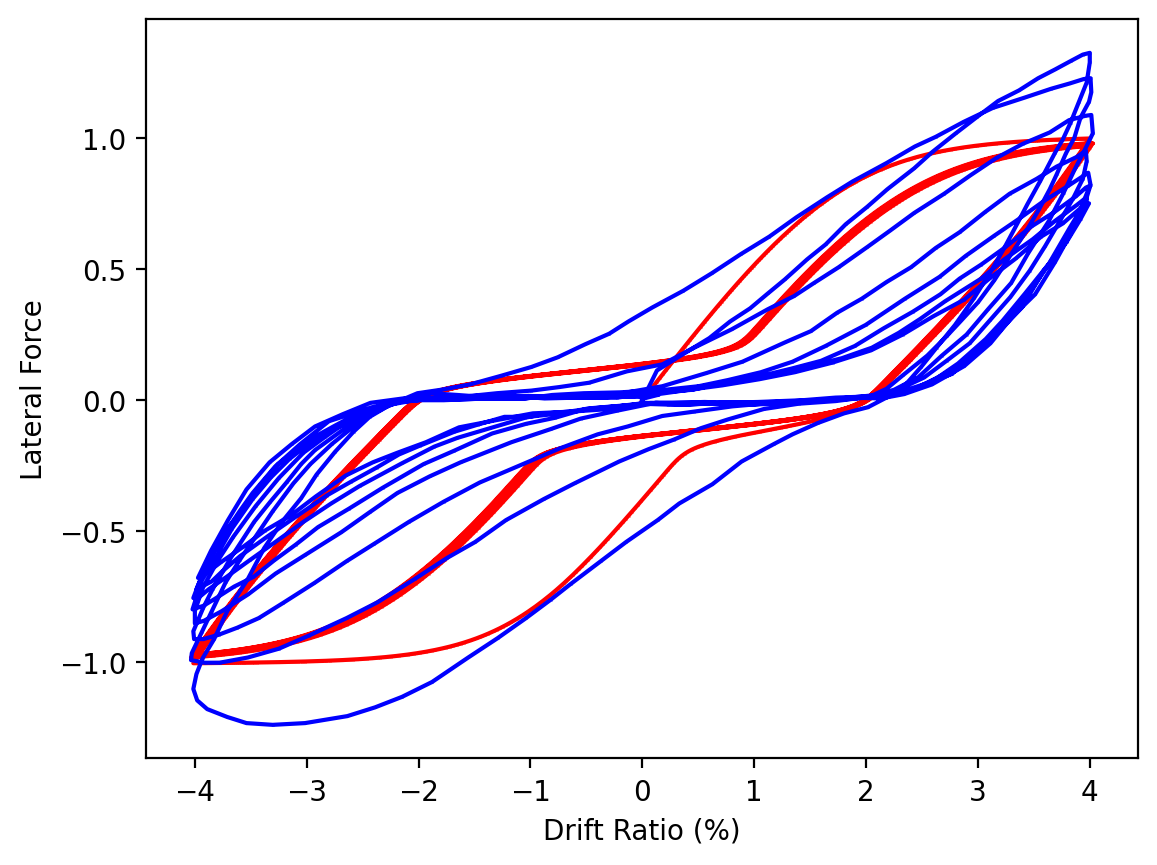

In [210]:
# Sample 10 random rows
model_params_mat = cal_data.sample(1, random_state=5)

plt.figure(dpi=200)

for ii in range(0, len(model_params_mat)):
    model_params = model_params_mat.iloc[ii, :]

    # print(model_params)
    strains, force, peak_force, L, test_data = get_response(model_params, testid)

    plt.plot(100 * np.array(strains)/L, np.array(force)/peak_force, 'r.-', markersize=0.2)
    plt.xlabel('Drift Ratio (%)')
    plt.ylabel('Lateral Force')

#plt.figure()
plt.plot(100 * np.array(test_data["data"]["disp"])/L, 1000 * np.array(test_data["data"]["force"])/peak_force, 'b.-', markersize=0.2)
plt.show()